# 주소데이터 기반 데이터셋 전처리
- 도로명 주소 기반 위경도 처리

In [ ]:
import pandas as pd
import requests, json, pprint
from tqdm import tqdm
from geopy.geocoders import Nominatim

geo_local = Nominatim(user_agent='South Korea')
API_KEY="개인APIKEY"

# 카카오API를 사용하여 좌표->주소 변환
def get_location_kakao(address_data):
  url = 'https://dapi.kakao.com/v2/local/search/address.json?query=' + address_data
  headers = {"Authorization": f"KakaoAK {API_KEY}"}
  api_json = json.loads(str(requests.get(url,headers=headers).text))
  address = api_json['documents'][0]['address']
  crd = f"{str(address['y'])}, {str(address['x'])}"
  
  return address, crd

def get_location_nominatim(address_data):
  geo = geo_local.geocode(address_data)
  crd = f"{str(geo.latitude)}, {str(geo.longitude)}"
  
  return crd

In [5]:
data = pd.read_csv("/Users/shinjh/Desktop/likelion/mid_project/dataset_교통접근성/company_info.csv", encoding='utf-8')
data.head()

,Unnamed: 0,name,address
0,0,삼성전자,경기도 수원시 영통구 삼성로 129
1,1,LG에너지솔루션,서울특별시 영등포구 여의대로 108 (여의도동)
2,2,SK하이닉스,경기도 이천시 부발읍 경충대로 2091 (아미리)
3,4,NAVER,경기도 성남시 분당구 불정로 6
4,5,삼성바이오로직스,인천광역시 연수구 송도바이오대로 300


In [76]:
data_sort = data[data['address'].str.contains("서울")]
data_sort = data_sort[['name', 'address']].reset_index(drop=True)

# 'lat'과 'lon' 열 신규생성
data_sort['lat'] = None
data_sort['lon'] = None

data_sort.head()

,name,address,lat,lon
0,LG에너지솔루션,서울특별시 영등포구 여의대로 108 (여의도동),None,None
1,LG화학,서울특별시 영등포구 여의대로 128,None,None
2,현대차,서울특별시 서초구 헌릉로 12(삼성동으로 옮길 예정),None,None
3,기아,서울특별시 서초구 헌릉로 12(삼성동으로 옮길 예정),None,None
4,KB금융,서울특별시 영등포구 국제금융로8길,None,None


In [ ]:

# for idx, i in tqdm(enumerate(range(len(data_sort)))):
#   try:
#     _, latlon = get_location_kakao(data_sort['address'][i])
#     lat, lon = latlon.split(",")
  
#   except Exception as e:  # 예외 발생 시 다른 패키지 사용
#     try:
#       print(f"can't find in kakaoAPI : {data_sort['address'][i]}, try in another package")
#       latlon = get_location_nominatim(data_sort['address'][i])
    
#     except:
#       print(f"SKIP : can't find : {data_sort['address'][i]}")
#       lat, lon = None, None  # 좌표를 None으로 설정
    
#   # 좌표 값 유효성 확인 후 데이터 저장
#   if lat is not None and lon is not None:
#       data_sort.at[i, 'lat'] = lat
#       data_sort.at[i, 'lon'] = lon

Location(국제금융로8길, 여의동, 영등포구, 서울특별시, 07332, 대한민국, (37.51941825, 126.92790455, 0.0))

In [87]:
data_sort.to_csv("./conpany_info_lonlat_add.csv")

# 데이터 별 구역 확인
- 100대 기업의 주소를 기반으로, 회사가 밀집되어있는 구역 5개 선정
- 해당 구역 기반으로 진행예정

In [88]:
display(data_sort)

,name,address,lat,lon
0,LG에너지솔루션,서울특별시 영등포구 여의대로 108 (여의도동),37.5251913154781,126.929112756574
1,LG화학,서울특별시 영등포구 여의대로 128,37.5279271045092,126.929241174348
2,현대차,서울특별시 서초구 헌릉로 12(삼성동으로 옮길 예정),37.4643623227152,127.042663599215
3,기아,서울특별시 서초구 헌릉로 12(삼성동으로 옮길 예정),37.4643623227152,127.042663599215
4,KB금융,서울특별시 영등포구 국제금융로8길,37.4643623227152,127.042663599215
...,...,...,...,...
62,아모레G,서울특별시 용산구 한강대로 100 아모레퍼시픽,37.5287911785354,126.968673565462
63,NH투자증권,서울특별시 영등포구 여의대로 108 파크원 NH금융타워(타워2),37.5251913154781,126.929112756574
64,GS건설,서울특별시 종로구 종로 33 그랑서울,37.5709617749066,126.981437983842
65,KCC,서울특별시 서초구 사평대로 344,37.5029945221484,127.020802535605


# 회사 - 아파트 간 거리 탐색

In [327]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import platform


data = pd.read_csv("/Users/shinjh/Desktop/likelion/mid_project/dataset_교통접근성/conpany_info_seoulonly_lonlat_add.csv")

In [328]:
data['spot'] = data['address'].apply(lambda x: x.strip().split(" ")[1])

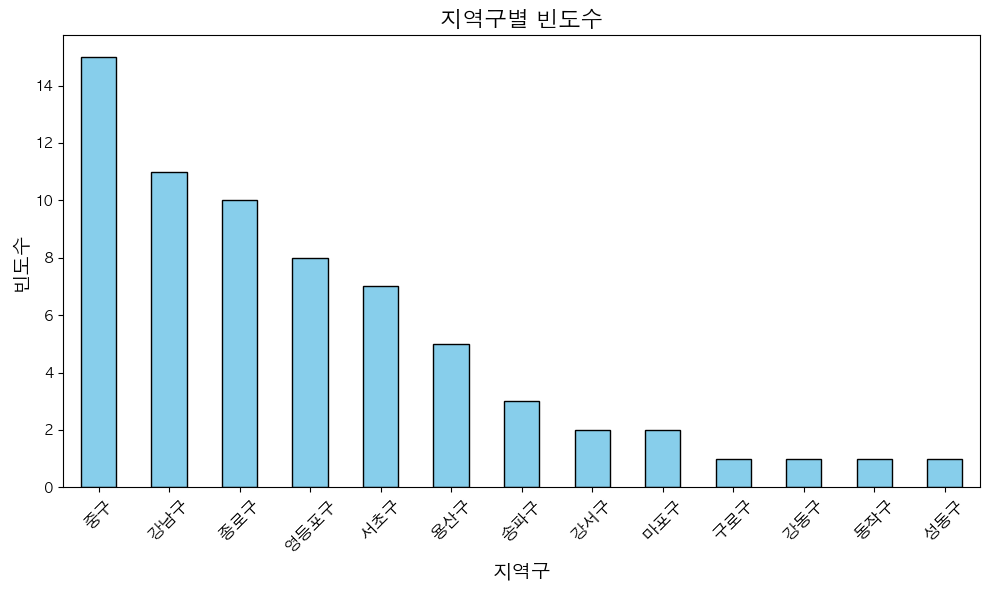

In [329]:
# Font setting
platform.system() == "Darwin"
rc('font', family='AppleGothic')  # macOS: 애플고딕

zone_counts = data['spot'].value_counts()

# 시각화
plt.figure(figsize=(10, 6))
zone_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('지역구별 빈도수', fontsize=16)
plt.xlabel('지역구', fontsize=14)
plt.ylabel('빈도수', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.tight_layout()
plt.show()

In [330]:
data[data['spot'] == '영등포구'].reset_index(drop=True)

,Unnamed: 0,name,address,lat,lon,spot
0,0,LG에너지솔루션,서울특별시 영등포구 여의대로 108 (여의도동),37.525191,126.929113,영등포구
1,1,LG화학,서울특별시 영등포구 여의대로 128,37.527927,126.929241,영등포구
2,4,KB금융,서울특별시 영등포구 국제금융로8길 2,37.521949,126.930145,영등포구
3,6,LG전자,서울특별시 영등포구 여의대로 128,37.527927,126.929241,영등포구
4,15,LG,서울특별시 영등포구 여의대로 128,37.527927,126.929241,영등포구
5,32,LG디스플레이,서울특별시 영등포구 여의대로 128,37.527927,126.929241,영등포구
6,50,한국금융지주,서울특별시 영등포구 의사당대로 88 한국투자증권빌딩,37.522085,126.922273,영등포구
7,63,NH투자증권,서울특별시 영등포구 여의대로 108 파크원 NH금융타워(타워2),37.525191,126.929113,영등포구


In [331]:
company_spot = data.groupby(by='spot').size().sort_values(ascending=False)
top_5 = company_spot.index.tolist()[0:5]

In [334]:
import folium

map_folium = folium.Map(location=[37.564963866666666, 126.98638033333333], zoom_start=11)
mean_lat_lon_list = []

for idx, i in enumerate(top_5):
    selected = data[data['spot'] == i].reset_index(drop=True)

    for k in range(len(selected)):
        popup = folium.Popup(f"{i} {selected.loc[k]['name']}", max_width=200)
        folium.Marker(location=[selected.loc[k]['lat'],selected.loc[k]['lon']], popup=popup).add_to(map_folium)   

    popup = folium.Popup(f"{i} 중간지점", max_width=200)
    folium.CircleMarker(location=[selected['lat'].mean(), selected['lon'].mean()], popup=popup,
                        radius=10, color='red', fill_color='#EC4074').add_to(map_folium) 
    
    mean_lat_lon_list.append([i, selected['lat'].mean(), selected['lon'].mean()])


In [335]:
map_folium

# 중간지점 데이터 활용 아파트 위치 체크

In [336]:
price_origin = pd.read_csv("/Users/shinjh/Desktop/likelion/mid_project/dataset_교통접근성/apt_price.csv")

In [337]:
price_list = price_origin.copy()
price_list = price_list[['시군구','번지','단지명','도로명','계약년월','계약일','거래금액(만원)']]

In [338]:
# 2024-11년 기준

date = 202410

selected_list = price_list[price_list['시군구'].str.contains('분당')]
selected_list.loc[:,'거래금액(만원)'] = selected_list['거래금액(만원)'].str.replace(',', '').astype(int)
selected_bundang =  selected_list[selected_list['계약년월']==date].sort_values(by='거래금액(만원)', ascending=False).reset_index(drop=True)
selected_bundang['시군구'] = selected_bundang['시군구'].str.replace(r'\s+\S*동$', '', regex=True)

selected_list = price_list[price_list['시군구'].str.contains('일산')]
selected_list.loc[:,'거래금액(만원)'] = selected_list['거래금액(만원)'].str.replace(',', '').astype(int)
selected_ilsan = selected_list[selected_list['계약년월']==date].sort_values(by='거래금액(만원)', ascending=False).reset_index(drop=True)
selected_ilsan['시군구'] = selected_ilsan['시군구'].str.replace(r'\s+\S*동$', '', regex=True)

selected_bundang['위도'] = ""
selected_bundang['경도'] = ""

selected_ilsan['위도'] = ""
selected_ilsan['경도'] = ""

In [30]:
selected_bundang

,시군구,번지,단지명,도로명,계약년월,계약일,거래금액(만원),위도,경도
0,경기도 성남시 분당구,558,백현마을8단지(대림),판교역로 72,202410,1,422500,,
1,경기도 성남시 분당구,6,파크뷰,정자일로 248,202410,15,369000,,
2,경기도 성남시 분당구,542,판교푸르지오그랑블,동판교로 123,202410,11,340000,,
3,경기도 성남시 분당구,542,판교푸르지오그랑블,동판교로 123,202410,31,340000,,
4,경기도 성남시 분당구,542,판교푸르지오그랑블,동판교로 123,202410,14,320000,,
...,...,...,...,...,...,...,...,...,...
260,경기도 성남시 분당구,212,무지개(12단지)(주공뜨란체),미금로22번길 10,202410,15,50000,,
261,경기도 성남시 분당구,147,목련마을SK,판교로743번길 7,202410,11,49500,,
262,경기도 성남시 분당구,180,미켈란쉐르빌,정자일로 100,202410,11,48000,,
263,경기도 성남시 분당구,180,미켈란쉐르빌,정자일로 100,202410,3,45000,,


In [31]:
selected_ilsan

,시군구,번지,단지명,도로명,계약년월,계약일,거래금액(만원),위도,경도
0,경기도 고양시 일산동구,1504,위시티일산자이4단지,위시티4로 45,202410,8,143000,,
1,경기도 고양시 일산동구,1753,킨텍스원시티1블럭,태극로 8,202410,24,129200,,
2,경기도 고양시 일산동구,1761,킨텍스원시티2블럭,월드고양로 19,202410,12,125300,,
3,경기도 고양시 일산동구,1762,킨텍스원시티3블럭,월드고양로 21,202410,12,122000,,
4,경기도 고양시 일산동구,875,호수마을(롯데),노루목로 79,202410,18,110000,,
...,...,...,...,...,...,...,...,...,...
349,경기도 고양시 일산동구,1555,중산마을1단지(두산),고봉로 424,202410,25,15900,,
350,경기도 고양시 일산동구,466-1,현대그린,성현로 508,202410,16,8000,,
351,경기도 고양시 일산동구,466-1,현대그린,성현로 508,202410,17,7500,,
352,경기도 고양시 일산동구,466-1,현대그린,성현로 508,202410,23,7400,,


In [32]:
from geopy.geocoders import Nominatim

# Nominatim으로 좌표 검색 함수
def get_location_nominatim(address_data):
    geolocator = Nominatim(user_agent="chaos")
    location = geolocator.geocode(address_data)
    if location:
        return location.latitude, location.longitude  # 위도, 경도 반환
    return None, None

In [33]:
for i in range(len(selected_bundang)):
    address = f"{selected_bundang['시군구'][i]} {selected_bundang['도로명'][i]}"
    lat, lon = get_location_nominatim(address)
    
    selected_bundang.loc[i,'위도']= lat
    selected_bundang.loc[i,'경도']= lon
    
    if lat is None or lon is None:
        print(f"Failed : {address}")
    
    else:
        print(f"{address} Done.")

경기도 성남시 분당구 판교역로 72 Done.
경기도 성남시 분당구 정자일로 248 Done.
경기도 성남시 분당구 동판교로 123 Done.
경기도 성남시 분당구 동판교로 123 Done.
경기도 성남시 분당구 동판교로 123 Done.
경기도 성남시 분당구 정자일로 248 Done.
경기도 성남시 분당구 정자일로 239 Done.
경기도 성남시 분당구 동판교로 123 Done.
경기도 성남시 분당구 판교역로 145 Done.
경기도 성남시 분당구 동판교로 153 Done.
경기도 성남시 분당구 동판교로 156 Done.
경기도 성남시 분당구 정자일로 248 Done.
경기도 성남시 분당구 판교역로 145 Done.
경기도 성남시 분당구 판교역로 145 Done.
경기도 성남시 분당구 동판교로 156 Done.
경기도 성남시 분당구 대왕판교로606번길 10 Done.
경기도 성남시 분당구 정자일로213번길 5 Done.
경기도 성남시 분당구 정자일로213번길 5 Done.
경기도 성남시 분당구 중앙공원로 17 Done.
경기도 성남시 분당구 중앙공원로 54 Done.
경기도 성남시 분당구 정자일로 239 Done.
경기도 성남시 분당구 중앙공원로 20 Done.
경기도 성남시 분당구 판교역로 145 Done.
경기도 성남시 분당구 판교역로 145 Done.
경기도 성남시 분당구 판교역로 72 Done.
경기도 성남시 분당구 정자일로 239 Done.
경기도 성남시 분당구 내정로166번길 42 Done.
경기도 성남시 분당구 동판교로 122 Done.
경기도 성남시 분당구 동판교로 122 Done.
경기도 성남시 분당구 동판교로 122 Done.
경기도 성남시 분당구 판교역로 100 Done.
경기도 성남시 분당구 판교역로 98 Done.
경기도 성남시 분당구 판교역로 100 Done.
경기도 성남시 분당구 판교역로 102 Done.
경기도 성남시 분당구 판교로 30 Done.
경기도 성남시 분당구 판교역로 98 Done.
경기도 성남시 분당구 판교대장로7길 

In [35]:
selected_bundang.head(5)

,시군구,번지,단지명,도로명,계약년월,계약일,거래금액(만원),위도,경도
0,경기도 성남시 분당구,558,백현마을8단지(대림),판교역로 72,202410,1,422500,37.388823,127.108452
1,경기도 성남시 분당구,6,파크뷰,정자일로 248,202410,15,369000,37.361916,127.105981
2,경기도 성남시 분당구,542,판교푸르지오그랑블,동판교로 123,202410,11,340000,37.401742,127.116886
3,경기도 성남시 분당구,542,판교푸르지오그랑블,동판교로 123,202410,31,340000,37.401742,127.116886
4,경기도 성남시 분당구,542,판교푸르지오그랑블,동판교로 123,202410,14,320000,37.401742,127.116886


In [39]:
for i in range(len(selected_ilsan)):
    address = f"{selected_ilsan['시군구'][i]} {selected_ilsan['도로명'][i]}"
    lat, lon = get_location_nominatim(address)
    
    selected_ilsan.loc[i,'위도']= lat
    selected_ilsan.loc[i,'경도']= lon
    
    if lat is None or lon is None:
        print(f"Failed : {address}")
    
    else:
        print(f"{address} Done.")

경기도 고양시 일산동구 위시티4로 45 Done.
경기도 고양시 일산동구 태극로 8 Done.
경기도 고양시 일산동구 월드고양로 19 Done.
경기도 고양시 일산동구 월드고양로 21 Done.
경기도 고양시 일산동구 노루목로 79 Done.
경기도 고양시 일산동구 강송로 33 Done.
경기도 고양시 일산동구 노루목로 79 Done.
경기도 고양시 일산동구 연리지로 50 Done.
경기도 고양시 일산동구 강송로 33 Done.
경기도 고양시 일산동구 위시티4로 45 Done.
경기도 고양시 일산동구 강송로 33 Done.
경기도 고양시 일산동구 강송로 33 Done.
경기도 고양시 일산동구 강석로 152 Done.
경기도 고양시 일산동구 일산로 241 Done.
경기도 고양시 일산동구 연리지로 50 Done.
경기도 고양시 일산동구 위시티4로 46 Done.
경기도 고양시 일산동구 일산로 205 Done.
경기도 고양시 일산동구 일산로 241 Done.
경기도 고양시 일산동구 위시티3로 111 Done.
경기도 고양시 일산동구 강석로 152 Done.
경기도 고양시 일산동구 위시티4로 45 Done.
경기도 고양시 일산서구 강선로 187 Done.
경기도 고양시 일산동구 위시티4로 45 Done.
경기도 고양시 일산동구 강송로 156 Done.
경기도 고양시 일산동구 강송로 195 Done.
경기도 고양시 일산동구 일산로 205 Done.
경기도 고양시 일산동구 위시티4로 45 Done.
경기도 고양시 일산서구 대산로 142 Done.
경기도 고양시 일산동구 위시티4로 79 Done.
경기도 고양시 일산서구 대산로 106 Done.
경기도 고양시 일산동구 위시티4로 80 Done.
경기도 고양시 일산동구 강송로 156 Done.
경기도 고양시 일산동구 중산로 70 Done.
경기도 고양시 일산동구 위시티4로 80 Done.
경기도 고양시 일산동구 노루목로 80 Done.
경기도 고양시 일산서구 대산로 161 Done.
경기도 고양시 일산서구 강선로 164 D

In [40]:
selected_bundang.to_csv("/Users/shinjh/Desktop/likelion/mid_project/dataset_교통접근성/dataset_apt_price_bundang_202410.csv", encoding='utf-8')
selected_ilsan.to_csv("/Users/shinjh/Desktop/likelion/mid_project/dataset_교통접근성/dataset_apt_price_ilsan_202410.csv", encoding='utf-8')

# 역 위치 근처 아파트 선정

In [341]:
import math

def haversine(lat1, lon1, lat2, lon2):
    # 지구 반지름(m)
    radius = 6371.0

    # to radian
    lat1 = math.radians(lat1)
    lon1 = math.radians(lon1)
    lat2 = math.radians(lat2)
    lon2 = math.radians(lon2)

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    # Haversine 공식 계산
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = radius * c

    return distance

In [342]:
selected_bundang = pd.read_csv("/Users/shinjh/Desktop/likelion/mid_project/dataset_교통접근성/dataset_apt_price_bundang_202410.csv", encoding='utf-8')
selected_ilsan = pd.read_csv("/Users/shinjh/Desktop/likelion/mid_project/dataset_교통접근성/dataset_apt_price_ilsan_202410.csv", encoding='utf-8')

In [343]:
data_station = pd.read_csv("/Users/shinjh/Desktop/likelion/mid_project/dataset_교통접근성/filtered_subway_station_data_일산분당신도시.csv")

In [344]:
data_station_bundang = data_station[data_station['역사도로명주소'].str.contains("성남", na=False)]
data_station_bundang = data_station_bundang[~data_station_bundang['역사명'].str.contains('모란역', case=False, na=False)] # 모란역제거
data_station_bundang = data_station_bundang[data_station_bundang['노선명'].str.contains("분당선", na=False)].reset_index(drop=True) # 분당선에 해당하는 역만 사용

data_station_ilsan = data_station[data_station['역사도로명주소'].str.contains("고양", na=False)]

In [345]:
data_station_bundang

,역번호,역사명,노선번호,노선명,영문역사명,한자역사명,환승역구분,환승노선번호,환승노선명,역위도,역경도,운영기관명,역사도로명주소,역사전화번호,데이터기준일자
0,1854,야탑역,I28K1,분당선,Yatap,野 塔,일반역,NaN,NaN,37.411320,127.128661,한국철도공사,경기도 성남시 성남대로 지하 903(야탑동 688-1),1544-7788,2024-05-31
1,1860,이매역,I28K1,분당선,Imae,二 梅,환승역,I41K5,경강선,37.395846,127.128272,한국철도공사,경기도 성남시 성남대로 지하 738,1544-7788,2024-05-31
2,1855,서현역,I28K1,분당선,Seohyeon,書 峴,일반역,NaN,NaN,37.384931,127.123249,한국철도공사,경기도 성남시 분당구 성남대로 지하 601,1544-7788,2024-05-31
3,1856,수내역,I28K1,분당선,Sunae,藪 內,일반역,NaN,NaN,37.378435,127.114216,한국철도공사,경기도 성남시 분당구 성남대로 지하 491(수내동),1544-7788,2024-05-31
4,1857,정자역,I28K1,분당선,Jeongja,亭 子,환승역,I41D1,신분당선,37.366037,127.108091,한국철도공사,경기도 성남시 분당구 성남대로 지하 333(정자동),1544-7788,2024-05-31
5,1858,미금역,I28K1,분당선,Migeum,美 金,일반역,NaN,NaN,37.350078,127.108952,한국철도공사,경기도 성남시 수정구 성남대로 지하 156,1544-7788,2024-05-31
6,1859,오리역,I28K1,분당선,Ori,梧 里,일반역,NaN,NaN,37.339832,127.108985,한국철도공사,경기도 성남시 분당구 성남대로 지하 55(구미동 795),1544-7788,2024-05-31


In [346]:
selected_bundang.head()

,Unnamed: 0,시군구,번지,단지명,도로명,계약년월,계약일,거래금액(만원),위도,경도
0,0,경기도 성남시 분당구,558,백현마을8단지(대림),판교역로 72,202410,1,422500,37.388823,127.108452
1,1,경기도 성남시 분당구,6,파크뷰,정자일로 248,202410,15,369000,37.361916,127.105981
2,2,경기도 성남시 분당구,542,판교푸르지오그랑블,동판교로 123,202410,11,340000,37.401742,127.116886
3,3,경기도 성남시 분당구,542,판교푸르지오그랑블,동판교로 123,202410,31,340000,37.401742,127.116886
4,4,경기도 성남시 분당구,542,판교푸르지오그랑블,동판교로 123,202410,14,320000,37.401742,127.116886


In [357]:
import folium

map_folium = folium.Map(location=[37.403470, 127.107123], zoom_start=12, zoom_control=False, tiles='cartodbpositron')
# mean_lat_lon_list = []

for idx, i in enumerate(range(len(data_station_bundang))):
    selected_station = data_station_bundang.iloc[i]

    popup = folium.Popup(f"{i} {selected_station.loc['역사명']}", max_width=200)
    folium.Circle(location=[selected_station.loc['역위도'], selected_station.loc['역경도']], fill=True, fill_opacity=1, popup=popup).add_to(map_folium)    
    
for idx, k in enumerate(range(len(selected_bundang))):
    selected = selected_bundang.loc[k]

    try:
        popup = folium.Popup(f"{k} {selected.loc['단지명']}", max_width=200)
        folium.Circle(location=[float(selected.loc['위도']), float(selected.loc['경도'])], popup=popup, fill=True, fill_opacity=1, color="red").add_to(map_folium)  
    except:
        print(f"MISSING : {selected.loc['단지명']} / {selected.loc['위도']} / {selected.loc['경도']}")
        continue

In [358]:
map_folium

In [359]:
import folium

map_folium = folium.Map(location=[37.670750, 126.816360], zoom_start=12, zoom_control=False, tiles='cartodbpositron')
# mean_lat_lon_list = []

for idx, i in enumerate(range(len(data_station_ilsan))):
    selected_station = data_station_ilsan.iloc[i]

    popup = folium.Popup(f"{i} {selected_station.loc['역사명']}", max_width=200)
    folium.Circle(location=[selected_station.loc['역위도'], selected_station.loc['역경도']], fill=True, fill_opacity=1, popup=popup).add_to(map_folium)    
    
for idx, k in enumerate(range(len(selected_ilsan))):
    selected = selected_ilsan.loc[k]

    try:
        popup = folium.Popup(f"{k} {selected.loc['단지명']}", max_width=200)
        folium.Circle(location=[float(selected.loc['위도']), float(selected.loc['경도'])], popup=popup, fill=True, fill_opacity=1, color="red").add_to(map_folium)  
    except:
        print(f"MISSING : {selected.loc['단지명']} / {selected.loc['위도']} / {selected.loc['경도']}")
        continue

MISSING : 신안인스빌1단지 / nan / nan
MISSING : 신안인스빌2단지 / nan / nan


In [360]:
# 신안인스빌 -> 일산리 (용인시 데이터 잘못되어서 필터링됨.) => 삭제조치
map_folium

In [18]:
selected_ilsan.head(5)

,Unnamed: 0,시군구,번지,단지명,도로명,계약년월,계약일,거래금액(만원),위도,경도
0,0,경기도 고양시 일산동구,1504,위시티일산자이4단지,위시티4로 45,202410,8,143000,37.681765,126.812352
1,1,경기도 고양시 일산동구,1753,킨텍스원시티1블럭,태극로 8,202410,24,129200,37.661631,126.752858
2,2,경기도 고양시 일산동구,1761,킨텍스원시티2블럭,월드고양로 19,202410,12,125300,37.655932,126.757882
3,3,경기도 고양시 일산동구,1762,킨텍스원시티3블럭,월드고양로 21,202410,12,122000,37.655932,126.757882
4,4,경기도 고양시 일산동구,875,호수마을(롯데),노루목로 79,202410,18,110000,37.649451,126.776650


## 분당

In [314]:
data_station_bundang

,역번호,역사명,노선번호,노선명,영문역사명,한자역사명,환승역구분,환승노선번호,환승노선명,역위도,역경도,운영기관명,역사도로명주소,역사전화번호,데이터기준일자
0,1854,야탑역,I28K1,분당선,Yatap,野 塔,일반역,NaN,NaN,37.411320,127.128661,한국철도공사,경기도 성남시 성남대로 지하 903(야탑동 688-1),1544-7788,2024-05-31
1,1860,이매역,I28K1,분당선,Imae,二 梅,환승역,I41K5,경강선,37.395846,127.128272,한국철도공사,경기도 성남시 성남대로 지하 738,1544-7788,2024-05-31
2,1855,서현역,I28K1,분당선,Seohyeon,書 峴,일반역,NaN,NaN,37.384931,127.123249,한국철도공사,경기도 성남시 분당구 성남대로 지하 601,1544-7788,2024-05-31
3,1856,수내역,I28K1,분당선,Sunae,藪 內,일반역,NaN,NaN,37.378435,127.114216,한국철도공사,경기도 성남시 분당구 성남대로 지하 491(수내동),1544-7788,2024-05-31
4,1857,정자역,I28K1,분당선,Jeongja,亭 子,환승역,I41D1,신분당선,37.366037,127.108091,한국철도공사,경기도 성남시 분당구 성남대로 지하 333(정자동),1544-7788,2024-05-31
5,1858,미금역,I28K1,분당선,Migeum,美 金,일반역,NaN,NaN,37.350078,127.108952,한국철도공사,경기도 성남시 수정구 성남대로 지하 156,1544-7788,2024-05-31
6,1859,오리역,I28K1,분당선,Ori,梧 里,일반역,NaN,NaN,37.339832,127.108985,한국철도공사,경기도 성남시 분당구 성남대로 지하 55(구미동 795),1544-7788,2024-05-31


야탑역
MISSING
이매역
MISSING
서현역
MISSING
수내역
MISSING
정자역
MISSING
미금역
MISSING
오리역
MISSING


In [21]:
selected_bundang.sort_values(by=['이매역-거리'])

,Unnamed: 0,시군구,번지,단지명,도로명,계약년월,계약일,거래금액(만원),위도,경도,야탑역-거리,이매역-거리,서현역-거리,수내역-거리,정자역-거리,미금역-거리,오리역-거리
60,60,경기도 성남시 분당구,123,이매촌(청구),양현로94번길 29,202410,5,163000,37.390775,127.128033,2.285169,0.564261,0.775167,1.836567,3.266707,4.829229,5.909434
67,67,경기도 성남시 분당구,123,이매촌(청구),양현로94번길 29,202410,18,155000,37.390775,127.128033,2.285169,0.564261,0.775167,1.836567,3.266707,4.829229,5.909434
135,135,경기도 성남시 분당구,123,이매촌(청구),양현로94번길 29,202410,3,120000,37.390775,127.128033,2.285169,0.564261,0.775167,1.836567,3.266707,4.829229,5.909434
255,255,경기도 성남시 분당구,205,매화마을(주공3),양현로 537,202410,3,55000,37.401252,127.125412,1.155737,0.652046,1.824819,2.723096,4.204132,5.873202,6.982135
48,48,경기도 성남시 분당구,133,아름마을(두산),탄천로 95,202410,19,170000,37.402210,127.123577,1.108082,0.820168,1.921512,2.769965,4.248572,5.939082,7.054925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253,253,경기도 성남시 분당구,212,무지개(12단지)(주공뜨란체),미금로22번길 10,202410,24,55500,37.336642,127.118818,8.349275,6.636022,5.383786,4.664967,3.403356,1.729985,0.938904
249,249,경기도 성남시 분당구,212,무지개(12단지)(주공뜨란체),미금로22번길 10,202410,31,57500,37.336642,127.118818,8.349275,6.636022,5.383786,4.664967,3.403356,1.729985,0.938904
248,248,경기도 성남시 분당구,212,무지개(12단지)(주공뜨란체),미금로22번길 10,202410,24,59800,37.336642,127.118818,8.349275,6.636022,5.383786,4.664967,3.403356,1.729985,0.938904
260,260,경기도 성남시 분당구,212,무지개(12단지)(주공뜨란체),미금로22번길 10,202410,15,50000,37.336642,127.118818,8.349275,6.636022,5.383786,4.664967,3.403356,1.729985,0.938904


In [43]:
top3_df_bundang = pd.DataFrame()
target_column = ["이매역-거리","야탑역-거리","서현역-거리","수내역-거리","정자역-거리","미금역-거리","오리역-거리"]


for idx, i in enumerate(range(len(target_column))):
    # 중복 값을 포함한 상위 3개 값 추출
    top_3_values = selected_bundang[target_column[i]].nsmallest(50).unique()[0:3] # 상위 3개의 고유 최소값 추출
    result = selected_bundang[selected_bundang[target_column[i]].isin(top_3_values)].sort_values(by=target_column[i])
    print(f"{target_column[i]} : {top_3_values}")
    unique_coordinates = result[["시군구","번지","단지명","도로명","계약년월","계약일", "거래금액(만원)", '위도', '경도']].drop_duplicates(subset=['위도', '경도']).reset_index(drop=True)
    unique_coordinates['기준위치'] = target_column[i]
    
    top3_df_bundang = pd.concat([top3_df_bundang, unique_coordinates])
    
top3_df_bundang = top3_df_bundang.reset_index(drop=True)
display(top3_df_bundang)

이매역-거리 : [0.56426074 0.65204603 0.82016819]
야탑역-거리 : [0.45965746 0.46341827 0.66044136]
서현역-거리 : [0.39433214 0.6916888  0.70457532]
수내역-거리 : [0.41901229 0.61441797 0.75835467]
정자역-거리 : [0.31486249 0.32679265 0.47993204]
미금역-거리 : [0.33799097 0.38429107 0.62593526]
오리역-거리 : [0.63079801 0.70358436 0.85189977]


,시군구,번지,단지명,도로명,계약년월,계약일,거래금액(만원),위도,경도,기준위치
0,경기도 성남시 분당구,123,이매촌(청구),양현로94번길 29,202410,5,163000,37.390775,127.128033,이매역-거리
1,경기도 성남시 분당구,205,매화마을(주공3),양현로 537,202410,3,55000,37.401252,127.125412,이매역-거리
2,경기도 성남시 분당구,133,아름마을(두산),탄천로 95,202410,19,170000,37.402210,127.123577,이매역-거리
3,경기도 성남시 분당구,330,장미마을(코오롱)1,장미로 55,202410,26,118000,37.413410,127.133151,야탑역-거리
4,경기도 성남시 분당구,201,매화마을공무원1,매화로 92,202410,2,73500,37.411524,127.133902,야탑역-거리
5,경기도 성남시 분당구,111,이매촌(진흥),양현로 138,202410,17,129000,37.416454,127.124901,야탑역-거리
6,경기도 성남시 분당구,35,샛별마을(동성),분당로 212,202410,9,90000,37.384835,127.118787,서현역-거리
7,경기도 성남시 분당구,71,푸른마을(벽산),수내로 174,202410,9,175500,37.379951,127.118557,서현역-거리
8,경기도 성남시 분당구,96,시범우성,중앙공원로 54,202410,19,220000,37.380618,127.129091,서현역-거리
9,경기도 성남시 분당구,71,푸른마을(벽산),수내로 174,202410,9,175500,37.379951,127.118557,수내역-거리


In [23]:
import folium

map_folium = folium.Map()
# mean_lat_lon_list = []

for idx, i in enumerate(range(len(data_station_bundang))):
    selected_station = data_station_bundang.iloc[i]

    popup = folium.Popup(f"{i} {selected_station.loc['역사명']}", max_width=200)
    folium.Circle(location=[selected_station.loc['역위도'], selected_station.loc['역경도']], fill=True, fill_opacity=1, popup=popup).add_to(map_folium)    
    
for idx, k in enumerate(range(len(top3_df_bundang))):
    selected = top3_df_bundang.loc[k]

    # try:
    popup = folium.Popup(f"{k} {selected.loc['단지명']}/{selected.loc['기준위치']}", max_width=30)
    folium.Circle(location=[float(selected.loc['위도']), float(selected.loc['경도'])], popup=popup, fill=True, fill_opacity=1, color="red").add_to(map_folium)  
    # except:
    #     print(f"MISSING : {selected.loc['단지명']} / {selected.loc['위도']} / {selected.loc['경도']}")
    #     continue
    
map_folium

In [26]:
top3_df_bundang.to_csv("/Users/shinjh/Desktop/likelion/mid_project/dataset_교통접근성/dataset_apt_price_bundang_top3_by_station.csv", encoding='utf-8')

## 일산

In [27]:
for idx, i in enumerate(range(len(data_station_ilsan))):
    selected_station = data_station_ilsan.iloc[i]
    selected_station_name = selected_station.loc['역사명']
    
    reference_lat = selected_station.loc['역위도']  # 서울 위도
    reference_lon = selected_station.loc['역경도']  # 서울 경도
    
    try:
        selected_ilsan[f'{selected_station_name}-거리'] = selected_ilsan.apply(
            lambda row: haversine(reference_lat, reference_lon, row['위도'], row['경도']) 
                        if pd.notna(row['위도']) and pd.notna(row['경도']) 
                        else None,  # 결측값은 None 또는 np.nan 반환
            axis=1
            )
    except :
        print(f"MISSING")
        continue
        

In [28]:
selected_ilsan.sort_values(by='백석역-거리').head(20)

,Unnamed: 0,시군구,번지,단지명,도로명,계약년월,계약일,거래금액(만원),위도,경도,백석역-거리,마두역-거리,정발산역-거리,주엽역-거리,대화역-거리
345,345,경기도 고양시 일산동구,806,강촌마을(한양6),중앙로 1130,202410,28,19200,37.641875,126.789410,0.167403,1.545283,2.440395,4.003715,5.267332
258,258,경기도 고양시 일산동구,902,호수마을(대우),중앙로 1129,202410,14,31900,37.641875,126.789410,0.167403,1.545283,2.440395,4.003715,5.267332
169,169,경기도 고양시 일산동구,1351,흰돌마을(청구),중앙로 1123,202410,15,42000,37.641875,126.789410,0.167403,1.545283,2.440395,4.003715,5.267332
346,346,경기도 고양시 일산동구,806,강촌마을(한양6),중앙로 1130,202410,23,18300,37.641875,126.789410,0.167403,1.545283,2.440395,4.003715,5.267332
340,340,경기도 고양시 일산동구,806,강촌마을(한양6),중앙로 1130,202410,25,19800,37.641875,126.789410,0.167403,1.545283,2.440395,4.003715,5.267332
286,286,경기도 고양시 일산동구,1194,흰돌마을(금호),중앙로 1124,202410,17,28800,37.641875,126.789410,0.167403,1.545283,2.440395,4.003715,5.267332
343,343,경기도 고양시 일산동구,806,강촌마을(한양6),중앙로 1130,202410,5,19400,37.641875,126.789410,0.167403,1.545283,2.440395,4.003715,5.267332
11,11,경기도 고양시 일산동구,1237,일산요진와이시티,강송로 33,202410,23,95500,37.642013,126.792441,0.396082,1.725477,2.593322,4.162773,5.445837
10,10,경기도 고양시 일산동구,1237,일산요진와이시티,강송로 33,202410,11,96000,37.642013,126.792441,0.396082,1.725477,2.593322,4.162773,5.445837
37,37,경기도 고양시 일산동구,1237,일산요진와이시티,강송로 33,202410,5,72500,37.642013,126.792441,0.396082,1.725477,2.593322,4.162773,5.445837


In [32]:
top3_df_ilsan = pd.DataFrame()
target_column = ['백석역-거리', '마두역-거리', '정발산역-거리', '주엽역-거리', '대화역-거리']


for idx, i in enumerate(range(len(target_column))):
    # 중복 값을 포함한 상위 3개 값 추출
    top_3_values = selected_ilsan[target_column[i]].nsmallest(50).unique()[0:3] # 상위 3개의 고유 최소값 추출
    result = selected_ilsan[selected_ilsan[target_column[i]].isin(top_3_values)].sort_values(by=target_column[i])
    print(f"{target_column[i]} : {top_3_values}")
    unique_coordinates = result[["시군구","번지","단지명","도로명","계약년월","계약일", "거래금액(만원)", '위도', '경도']].drop_duplicates(subset=['위도', '경도']).reset_index(drop=True)
    unique_coordinates['기준위치'] = target_column[i]
    
    top3_df_ilsan = pd.concat([top3_df_ilsan, unique_coordinates])
    
top3_df_ilsan = top3_df_ilsan.reset_index(drop=True)
display(top3_df_ilsan)

백석역-거리 : [0.16740285 0.39608197 0.6013836 ]
마두역-거리 : [0.20264905 0.30902017 0.31627327]
정발산역-거리 : [0.80066536 0.9195731  0.99957907]
주엽역-거리 : [0.21540954 0.30901706 0.55467453]
대화역-거리 : [0.12714732 0.3413736  0.39884241]


,시군구,번지,단지명,도로명,계약년월,계약일,거래금액(만원),위도,경도,기준위치
0,경기도 고양시 일산동구,1351,흰돌마을(청구),중앙로 1123,202410,15,42000,37.641875,126.789410,백석역-거리
1,경기도 고양시 일산동구,1237,일산요진와이시티,강송로 33,202410,17,108500,37.642013,126.792441,백석역-거리
2,경기도 고양시 일산동구,757,강촌마을(동아),강송로 196,202410,20,70500,37.648381,126.787986,백석역-거리
3,경기도 고양시 일산동구,796,강촌마을(코오롱),강석로 152,202410,9,95000,37.653141,126.779601,마두역-거리
4,경기도 고양시 일산동구,875,호수마을(롯데),노루목로 79,202410,26,108500,37.649497,126.776750,마두역-거리
5,경기도 고양시 일산동구,875,호수마을(롯데),노루목로 79,202410,18,110000,37.649451,126.776650,마두역-거리
6,경기도 고양시 일산동구,1555,중산마을1단지(두산),고봉로 424,202410,21,23800,37.664327,126.766275,정발산역-거리
7,경기도 고양시 일산동구,796,강촌마을(코오롱),강석로 152,202410,9,95000,37.653141,126.779601,정발산역-거리
8,경기도 고양시 일산동구,794,강촌마을(우방),강송로 195,202410,30,82000,37.654764,126.782737,정발산역-거리
9,경기도 고양시 일산서구,23,문촌마을9단지주공,주엽로 156,202410,15,39000,37.671960,126.760400,주엽역-거리


In [39]:
import folium

map_folium = folium.Map()
# mean_lat_lon_list = []

for idx, i in enumerate(range(len(data_station_ilsan))):
    selected_station = data_station_ilsan.iloc[i]

    popup = folium.Popup(f"{i} {selected_station.loc['역사명']}", max_width=200)
    folium.Circle(location=[selected_station.loc['역위도'], selected_station.loc['역경도']], fill=True, fill_opacity=1, popup=popup).add_to(map_folium)    
    
for idx, k in enumerate(range(len(top3_df_ilsan))):
    selected = top3_df_ilsan.loc[k]

    # try:
    popup = folium.Popup(f"{k} {selected.loc['단지명']}/{selected.loc['기준위치']}", max_width=10)
    folium.Circle(location=[float(selected.loc['위도']), float(selected.loc['경도'])], popup=popup, color="red").add_to(map_folium)  
    # except:
    #     print(f"MISSING : {selected.loc['단지명']} / {selected.loc['위도']} / {selected.loc['경도']}")
    #     continue
    
map_folium

In [33]:
top3_df_ilsan.to_csv("/Users/shinjh/Desktop/likelion/mid_project/dataset_교통접근성/dataset_apt_price_ilsan_top3_by_station.csv", encoding='utf-8')

# 회사 별 위치 중간지점

In [44]:
mean_lat_lon_list = [['중구', 37.56496378420572, 126.98638035749214],
                    ['강남구', 37.502597821500075, 127.03775216369364],
                    ['종로구', 37.57334034521065, 126.98365886796088],
                    ['영등포구', 37.52576565325149, 126.92845099895187],
                    ['서초구', 37.483616105357044, 127.03267809993557]]

In [45]:
for name, mean_lat, mean_lon in mean_lat_lon_list:
    column_name = f"{name}_직선거리"
    top3_df_bundang[column_name] = top3_df_bundang.apply(lambda row: haversine(row["위도"], row["경도"], mean_lat, mean_lon), axis=1)

top3_df_bundang

,시군구,번지,단지명,도로명,계약년월,계약일,거래금액(만원),위도,경도,기준위치,중구_직선거리,강남구_직선거리,종로구_직선거리,영등포구_직선거리,서초구_직선거리
0,경기도 성남시 분당구,123,이매촌(청구),양현로94번길 29,202410,5,163000,37.390775,127.128033,이매역-거리,23.052100,14.769130,23.966469,23.143927,13.321117
1,경기도 성남시 분당구,205,매화마을(주공3),양현로 537,202410,3,55000,37.401252,127.125412,이매역-거리,21.951744,13.670074,22.860226,22.223555,12.284311
2,경기도 성남시 분당구,133,아름마을(두산),탄천로 95,202410,19,170000,37.402210,127.123577,이매역-거리,21.773063,13.490797,22.682624,22.030494,12.097056
3,경기도 성남시 분당구,330,장미마을(코오롱)1,장미로 55,202410,26,118000,37.413410,127.133151,야탑역-거리,21.252752,13.009852,22.140390,21.964528,11.815685
4,경기도 성남시 분당구,201,매화마을공무원1,매화로 92,202410,2,73500,37.411524,127.133902,야탑역-거리,21.459624,13.212937,22.348496,22.138891,12.004601
5,경기도 성남시 분당구,111,이매촌(진흥),양현로 138,202410,17,129000,37.416454,127.124901,야탑역-거리,20.544058,12.285020,21.438225,21.173316,11.047575
6,경기도 성남시 분당구,35,샛별마을(동성),분당로 212,202410,9,90000,37.384835,127.118787,서현역-거리,23.188410,14.921432,24.115056,22.974836,13.358593
7,경기도 성남시 분당구,71,푸른마을(벽산),수내로 174,202410,9,175500,37.379951,127.118557,서현역-거리,23.649225,15.390877,24.578887,23.334394,13.797525
8,경기도 성남시 분당구,96,시범우성,중앙공원로 54,202410,19,220000,37.380618,127.129091,서현역-거리,24.058090,15.779628,24.978659,23.961746,14.270210
9,경기도 성남시 분당구,71,푸른마을(벽산),수내로 174,202410,9,175500,37.379951,127.118557,수내역-거리,23.649225,15.390877,24.578887,23.334394,13.797525


In [46]:
for name, mean_lat, mean_lon in mean_lat_lon_list:
    column_name = f"{name}_직선거리"
    top3_df_ilsan[column_name] = top3_df_ilsan.apply(lambda row: haversine(row["위도"], row["경도"], mean_lat, mean_lon), axis=1)

top3_df_ilsan

,시군구,번지,단지명,도로명,계약년월,계약일,거래금액(만원),위도,경도,기준위치,중구_직선거리,강남구_직선거리,종로구_직선거리,영등포구_직선거리,서초구_직선거리
0,경기도 고양시 일산동구,1351,흰돌마을(청구),중앙로 1123,202410,15,42000,37.641875,126.789410,백석역-거리,19.345085,26.811843,18.731598,17.798857,27.738916
1,경기도 고양시 일산동구,1237,일산요진와이시티,강송로 33,202410,17,108500,37.642013,126.792441,백석역-거리,19.112768,26.603122,18.494292,17.627284,27.542684
2,경기도 고양시 일산동구,757,강촌마을(동아),강송로 196,202410,20,70500,37.648381,126.787986,백석역-거리,19.785573,27.336213,19.149461,18.414051,28.298156
3,경기도 고양시 일산동구,796,강촌마을(코오롱),강석로 152,202410,9,95000,37.653141,126.779601,마두역-거리,20.686023,28.244535,20.044998,19.303247,29.203662
4,경기도 고양시 일산동구,875,호수마을(롯데),노루목로 79,202410,26,108500,37.649497,126.776750,마두역-거리,20.720965,28.211214,20.096808,19.182358,29.138284
5,경기도 고양시 일산동구,875,호수마을(롯데),노루목로 79,202410,18,110000,37.649451,126.776650,마두역-거리,20.726484,28.215429,20.102629,19.184822,29.141861
6,경기도 고양시 일산동구,1555,중산마을1단지(두산),고봉로 424,202410,21,23800,37.664327,126.766275,정발산역-거리,22.314452,29.927724,21.655064,21.012941,30.902848
7,경기도 고양시 일산동구,796,강촌마을(코오롱),강석로 152,202410,9,95000,37.653141,126.779601,정발산역-거리,20.686023,28.244535,20.044998,19.303247,29.203662
8,경기도 고양시 일산동구,794,강촌마을(우방),강송로 195,202410,30,82000,37.654764,126.782737,정발산역-거리,20.530248,28.130456,19.879108,19.250633,29.110636
9,경기도 고양시 일산서구,23,문촌마을9단지주공,주엽로 156,202410,15,39000,37.671960,126.760400,주엽역-거리,23.188377,30.852712,22.513935,21.987604,31.848639


In [47]:
top3_df_bundang.to_csv("/Users/shinjh/Desktop/likelion/mid_project/dataset_교통접근성/dataset_apt_price_bundang_top3_by_station_straight_line.csv", encoding='utf-8')
top3_df_ilsan.to_csv("/Users/shinjh/Desktop/likelion/mid_project/dataset_교통접근성/dataset_apt_price_ilsan_top3_by_station_straight_line.csv", encoding='utf-8')

## 네비게이션 기반_거리 계산법 적용 (KAKAOAPI)

In [118]:
mean_lat_lon_list = [['중구', 37.56496378420572, 126.98638035749214],
                    ['강남구', 37.502597821500075, 127.03775216369364],
                    ['종로구', 37.57334034521065, 126.98365886796088],
                    ['영등포구', 37.52576565325149, 126.92845099895187],
                    ['서초구', 37.483616105357044, 127.03267809993557]]

In [119]:
top3_df_bundang = pd.read_csv("/Users/shinjh/Desktop/likelion/mid_project/dataset_교통접근성/dataset_apt_price_bundang_top3_by_station_straight_line.csv", encoding='utf-8')
top3_df_ilsan = pd.read_csv("/Users/shinjh/Desktop/likelion/mid_project/dataset_교통접근성/dataset_apt_price_ilsan_top3_by_station_straight_line.csv", encoding='utf-8')

In [ ]:
from urllib.parse import urlencode

API_KEY="개인API_KEY"

def api_future_driving_info(origin_lon, origin_lat, dest_lon, dest_lat, time):
    # 요청 데이터
    url = "https://apis-navi.kakaomobility.com/v1/future/directions"
    headers = {
        "Authorization": f"KakaoAK {API_KEY}",
        "Content-Type": "application/json"
    }
    params = {
        "origin": f"{origin_lat}, {origin_lon}",  # 출발지 (서울특별시청)
        "destination": f"{dest_lat}, {dest_lon}",  # 목적지 (서울 강남구 삼성동)
        "departure_time" : str(time),
    }

    # API 요청
    response = requests.get(f"{url}?{urlencode(params)}", headers=headers)

    # 결과 확인
    if response.status_code == 200:
        result = response.json()
        result_dist = next(iter([section['distance'] for route in result['routes'] for section in route['sections']]))
        result_time = next(iter([section['duration'] for route in result['routes'] for section in route['sections']]))
    else:
        print("API 호출 실패:", response.status_code, response.text)
        
    return result_dist, result_time

def apply_future_driving_info(row, name, mean_lat, mean_lon):
    # API 호출
    result_dist, result_time = api_future_driving_info(row["경도"], row["위도"], mean_lon, mean_lat, row["출발시간"])
    
    # 반환된 직선거리와 시간을 반환
    return [result_dist, result_time]  # 예시로 직선거리만 사용

In [123]:
for name, mean_lat, mean_lon in mean_lat_lon_list:
    for date in range(20241202,20241207):
        top3_df_bundang[f"{name}_{date}_미래운행거리_시간_오전8시"] = top3_df_bundang.apply(lambda row: api_future_driving_info(row["위도"], row["경도"], mean_lat, mean_lon, int(f"{date}0800")), axis=1)
        print(f"Done : {date} {name} 오전8시")
        
        top3_df_bundang[f"{name}_{date}_미래운행거리_시간_낮12시"] = top3_df_bundang.apply(lambda row: api_future_driving_info(row["위도"], row["경도"], mean_lat, mean_lon, int(f"{date}1200")), axis=1)
        print(f"Done : {date} {name} 낮12시")
        
        top3_df_bundang[f"{name}_{date}_미래운행거리_시간_오후6시"] = top3_df_bundang.apply(lambda row: api_future_driving_info(row["위도"], row["경도"], mean_lat, mean_lon, int(f"{date}1800")), axis=1)
        print(f"Done : {date} {name} 오후6시")

top3_df_bundang

Done : 20241202 중구 오전8시
Done : 20241202 중구 낮12시
Done : 20241202 중구 오후6시
Done : 20241203 중구 오전8시
Done : 20241203 중구 낮12시
Done : 20241203 중구 오후6시
Done : 20241204 중구 오전8시
Done : 20241204 중구 낮12시
Done : 20241204 중구 오후6시
Done : 20241205 중구 오전8시
Done : 20241205 중구 낮12시
Done : 20241205 중구 오후6시
Done : 20241206 중구 오전8시
Done : 20241206 중구 낮12시
Done : 20241206 중구 오후6시
Done : 20241202 강남구 오전8시
Done : 20241202 강남구 낮12시
Done : 20241202 강남구 오후6시
Done : 20241203 강남구 오전8시
Done : 20241203 강남구 낮12시
Done : 20241203 강남구 오후6시
Done : 20241204 강남구 오전8시
Done : 20241204 강남구 낮12시
Done : 20241204 강남구 오후6시
Done : 20241205 강남구 오전8시
Done : 20241205 강남구 낮12시
Done : 20241205 강남구 오후6시
Done : 20241206 강남구 오전8시
Done : 20241206 강남구 낮12시
Done : 20241206 강남구 오후6시
Done : 20241202 종로구 오전8시
Done : 20241202 종로구 낮12시
Done : 20241202 종로구 오후6시
Done : 20241203 종로구 오전8시
Done : 20241203 종로구 낮12시
Done : 20241203 종로구 오후6시
Done : 20241204 종로구 오전8시
Done : 20241204 종로구 낮12시
Done : 20241204 종로구 오후6시
Done : 20241205 종로구 오전8시
Done : 20241205

,Unnamed: 0,시군구,번지,단지명,도로명,계약년월,계약일,거래금액(만원),위도,경도,...,서초구_20241203_미래운행거리_시간_오후6시,서초구_20241204_미래운행거리_시간_오전8시,서초구_20241204_미래운행거리_시간_낮12시,서초구_20241204_미래운행거리_시간_오후6시,서초구_20241205_미래운행거리_시간_오전8시,서초구_20241205_미래운행거리_시간_낮12시,서초구_20241205_미래운행거리_시간_오후6시,서초구_20241206_미래운행거리_시간_오전8시,서초구_20241206_미래운행거리_시간_낮12시,서초구_20241206_미래운행거리_시간_오후6시
0,0,경기도 성남시 분당구,123,이매촌(청구),양현로94번길 29,202410,5,163000,37.390775,127.128033,...,"(17969, 2162)","(15180, 2452)","(16551, 1519)","(17969, 2219)","(19499, 2247)","(16551, 1564)","(15180, 2185)","(15180, 2361)","(16551, 1647)","(15180, 2691)"
1,1,경기도 성남시 분당구,205,매화마을(주공3),양현로 537,202410,3,55000,37.401252,127.125412,...,"(15611, 2259)","(16016, 2668)","(15611, 1680)","(15611, 2229)","(17507, 2295)","(15611, 1736)","(15977, 2290)","(15977, 2297)","(15611, 1733)","(15873, 2772)"
2,2,경기도 성남시 분당구,133,아름마을(두산),탄천로 95,202410,19,170000,37.402210,127.123577,...,"(15342, 2243)","(15961, 2657)","(15342, 1667)","(15342, 2219)","(17452, 2306)","(15342, 1715)","(15342, 2297)","(15922, 2299)","(15342, 1721)","(16142, 2876)"
3,3,경기도 성남시 분당구,330,장미마을(코오롱)1,장미로 55,202410,26,118000,37.413410,127.133151,...,"(15231, 2138)","(15270, 2622)","(15231, 1561)","(15231, 2198)","(16761, 2264)","(15231, 1664)","(15231, 2260)","(15231, 2256)","(15231, 1670)","(15397, 2675)"
4,4,경기도 성남시 분당구,201,매화마을공무원1,매화로 92,202410,2,73500,37.411524,127.133902,...,"(15511, 2192)","(15545, 2736)","(15511, 1642)","(15506, 2332)","(17036, 2358)","(15506, 1742)","(15511, 2303)","(15506, 2311)","(15506, 1735)","(15672, 2771)"
5,5,경기도 성남시 분당구,111,이매촌(진흥),양현로 138,202410,17,129000,37.416454,127.124901,...,"(14976, 2104)","(15015, 2665)","(14976, 1601)","(14976, 2220)","(16506, 2295)","(14976, 1691)","(14976, 2268)","(14976, 2285)","(14976, 1695)","(15142, 2668)"
6,6,경기도 성남시 분당구,35,샛별마을(동성),분당로 212,202410,9,90000,37.384835,127.118787,...,"(16986, 1986)","(17025, 2451)","(16986, 1489)","(16986, 2053)","(17702, 2153)","(16986, 1600)","(16986, 2133)","(16986, 2126)","(16986, 1600)","(15000, 2739)"
7,7,경기도 성남시 분당구,71,푸른마을(벽산),수내로 174,202410,9,175500,37.379951,127.118557,...,"(16758, 1935)","(16797, 2377)","(16758, 1478)","(16758, 1970)","(17474, 2096)","(16758, 1575)","(16758, 2041)","(16758, 2090)","(16758, 1586)","(15140, 2632)"
8,8,경기도 성남시 분당구,96,시범우성,중앙공원로 54,202410,19,220000,37.380618,127.129091,...,"(18062, 2260)","(18088, 2843)","(18049, 1695)","(18109, 2276)","(18088, 2613)","(18049, 1797)","(18062, 2356)","(18049, 2381)","(18049, 1786)","(16076, 2992)"
9,9,경기도 성남시 분당구,71,푸른마을(벽산),수내로 174,202410,9,175500,37.379951,127.118557,...,"(16758, 1922)","(16797, 2377)","(16758, 1478)","(16758, 1970)","(17474, 2096)","(16758, 1575)","(16758, 2041)","(16758, 2090)","(16758, 1586)","(15140, 2632)"


In [124]:
top3_df_bundang.iloc[:,1:].to_csv("/Users/shinjh/Desktop/likelion/mid_project/dataset_교통접근성/dataset_apt_price_bundang_top3_driving_result_5_days.csv", index=False)

In [125]:
for name, mean_lat, mean_lon in mean_lat_lon_list:
    for date in range(20241202,20241207):
        top3_df_ilsan[f"{name}_{date}_미래운행거리_시간_오전8시"] = top3_df_ilsan.apply(lambda row: api_future_driving_info(row["위도"], row["경도"], mean_lat, mean_lon, int(f"{date}0800")), axis=1)
        print(f"Done : {date} {name} 오전8시")
        
        top3_df_ilsan[f"{name}_{date}_미래운행거리_시간_낮12시"] = top3_df_ilsan.apply(lambda row: api_future_driving_info(row["위도"], row["경도"], mean_lat, mean_lon, int(f"{date}1200")), axis=1)
        print(f"Done : {date} {name} 낮12시")
        
        top3_df_ilsan[f"{name}_{date}_미래운행거리_시간_오후6시"] = top3_df_ilsan.apply(lambda row: api_future_driving_info(row["위도"], row["경도"], mean_lat, mean_lon, int(f"{date}1800")), axis=1)
        print(f"Done : {date} {name} 오후6시")

top3_df_ilsan

Done : 20241202 중구 오전8시
Done : 20241202 중구 낮12시
Done : 20241202 중구 오후6시
Done : 20241203 중구 오전8시
Done : 20241203 중구 낮12시
Done : 20241203 중구 오후6시
Done : 20241204 중구 오전8시
Done : 20241204 중구 낮12시
Done : 20241204 중구 오후6시
Done : 20241205 중구 오전8시
Done : 20241205 중구 낮12시
Done : 20241205 중구 오후6시
Done : 20241206 중구 오전8시
Done : 20241206 중구 낮12시
Done : 20241206 중구 오후6시
Done : 20241202 강남구 오전8시
Done : 20241202 강남구 낮12시
Done : 20241202 강남구 오후6시
Done : 20241203 강남구 오전8시
Done : 20241203 강남구 낮12시
Done : 20241203 강남구 오후6시
Done : 20241204 강남구 오전8시
Done : 20241204 강남구 낮12시
Done : 20241204 강남구 오후6시
Done : 20241205 강남구 오전8시
Done : 20241205 강남구 낮12시
Done : 20241205 강남구 오후6시
Done : 20241206 강남구 오전8시
Done : 20241206 강남구 낮12시
Done : 20241206 강남구 오후6시
Done : 20241202 종로구 오전8시
Done : 20241202 종로구 낮12시
Done : 20241202 종로구 오후6시
Done : 20241203 종로구 오전8시
Done : 20241203 종로구 낮12시
Done : 20241203 종로구 오후6시
Done : 20241204 종로구 오전8시
Done : 20241204 종로구 낮12시
Done : 20241204 종로구 오후6시
Done : 20241205 종로구 오전8시
Done : 20241205

,Unnamed: 0,시군구,번지,단지명,도로명,계약년월,계약일,거래금액(만원),위도,경도,...,서초구_20241203_미래운행거리_시간_오후6시,서초구_20241204_미래운행거리_시간_오전8시,서초구_20241204_미래운행거리_시간_낮12시,서초구_20241204_미래운행거리_시간_오후6시,서초구_20241205_미래운행거리_시간_오전8시,서초구_20241205_미래운행거리_시간_낮12시,서초구_20241205_미래운행거리_시간_오후6시,서초구_20241206_미래운행거리_시간_오전8시,서초구_20241206_미래운행거리_시간_낮12시,서초구_20241206_미래운행거리_시간_오후6시
0,0,경기도 고양시 일산동구,1351,흰돌마을(청구),중앙로 1123,202410,15,42000,37.641875,126.789410,...,"(34599, 4053)","(36569, 5074)","(34331, 2785)","(34335, 3741)","(33948, 4651)","(36073, 3001)","(33858, 4116)","(34409, 4316)","(33858, 3010)","(34019, 4651)"
1,1,경기도 고양시 일산동구,1237,일산요진와이시티,강송로 33,202410,17,108500,37.642013,126.792441,...,"(34255, 4363)","(34804, 5241)","(34528, 3097)","(34484, 3821)","(34484, 4675)","(32970, 3165)","(34484, 3948)","(34357, 4883)","(32970, 3262)","(35396, 4729)"
2,2,경기도 고양시 일산동구,757,강촌마을(동아),강송로 196,202410,20,70500,37.648381,126.787986,...,"(35622, 4206)","(37652, 5140)","(35354, 2938)","(35358, 3915)","(37608, 4756)","(33745, 3219)","(37608, 4058)","(35432, 4502)","(34881, 3213)","(36143, 4797)"
3,3,경기도 고양시 일산동구,796,강촌마을(코오롱),강석로 152,202410,9,95000,37.653141,126.779601,...,"(37643, 4305)","(37428, 5143)","(35861, 3180)","(37375, 3950)","(37375, 4738)","(35766, 3281)","(37375, 4125)","(35861, 4888)","(36902, 3376)","(37676, 4916)"
4,4,경기도 고양시 일산동구,875,호수마을(롯데),노루목로 79,202410,26,108500,37.649497,126.776750,...,"(36133, 4192)","(37874, 5163)","(37275, 3058)","(37271, 3978)","(37875, 4757)","(37919, 3223)","(37875, 4121)","(37921, 4885)","(35392, 3343)","(37875, 4704)"
5,5,경기도 고양시 일산동구,875,호수마을(롯데),노루목로 79,202410,18,110000,37.649451,126.776650,...,"(36143, 4193)","(37864, 5159)","(37265, 3056)","(37865, 4067)","(37865, 4755)","(37909, 3221)","(37865, 4119)","(37911, 4883)","(35402, 3344)","(37865, 4703)"
6,6,경기도 고양시 일산동구,1555,중산마을1단지(두산),고봉로 424,202410,21,23800,37.664327,126.766275,...,"(38133, 4409)","(38658, 5215)","(38605, 3224)","(37865, 4041)","(38605, 4819)","(36996, 3398)","(37865, 4175)","(37091, 4926)","(37392, 3540)","(37865, 4963)"
7,7,경기도 고양시 일산동구,796,강촌마을(코오롱),강석로 152,202410,9,95000,37.653141,126.779601,...,"(37643, 4305)","(37428, 5143)","(37375, 3100)","(37375, 3950)","(37375, 4738)","(35766, 3281)","(37375, 4125)","(35861, 4888)","(36902, 3376)","(37676, 4916)"
8,8,경기도 고양시 일산동구,794,강촌마을(우방),강송로 195,202410,30,82000,37.654764,126.782737,...,"(38127, 4198)","(37945, 5248)","(37859, 3074)","(37859, 3945)","(37859, 4777)","(37386, 3233)","(37859, 4095)","(36345, 4891)","(37386, 3376)","(37859, 4789)"
9,9,경기도 고양시 일산서구,23,문촌마을9단지주공,주엽로 156,202410,15,39000,37.671960,126.760400,...,"(40766, 4491)","(40606, 5357)","(40520, 3333)","(40498, 4182)","(40520, 4994)","(40047, 3416)","(40498, 4231)","(39006, 4957)","(38984, 3702)","(40799, 5104)"


In [126]:
top3_df_ilsan.iloc[:,1:].to_csv("/Users/shinjh/Desktop/likelion/mid_project/dataset_교통접근성/dataset_apt_price_ilsan_top3_driving_result_5_days.csv", index=False)

## 시간대별 소요시간 평균 도출

- distance	: Int	전체 검색 결과 거리(미터)
- duration	: Int	목적지까지 소요 시간(초)

- 예측범위 241202 - 241206 예측 소요시간 (오전8시, 낮12시, 오후 6시)

In [291]:
import pandas as pd

bundang_result_origin = pd.read_csv("/Users/shinjh/Desktop/likelion/mid_project/dataset_교통접근성/dataset_apt_price_bundang_top3_driving_result_5_days.csv", encoding='utf-8')
ilsan_result_origin = pd.read_csv("/Users/shinjh/Desktop/likelion/mid_project/dataset_교통접근성/dataset_apt_price_ilsan_top3_driving_result_5_days.csv", encoding='utf-8')

In [125]:
bundang_result = bundang_result_origin.copy()
bundang_result = bundang_result.iloc[:, 0:15]

for spot in ['중구','강남구','종로구','영등포구','서초구']:
    # 운행거리 데이터 평균
    selected_data_dist = bundang_result_origin.filter(regex=f'{spot}.*미래운행거리')
        
    distance_data = selected_data_dist.apply(lambda col: col.map(lambda x: int(x.split(',')[0].lstrip('(')) if isinstance(x, str) else 0))

    selected_word_dist = f'{spot}_평균운행거리'
    bundang_result[selected_word_dist] = distance_data.mean(axis=1)

for spot in ['중구','강남구','종로구','영등포구','서초구']:
    # 시간 순 데이터 평균
    for time in ['오전8시','낮12시','오후6시']:
        selected_data_time = bundang_result_origin.filter(regex=fr'^{spot}.*{time}$')

        # 소요시간만 추출하여 'time_data' 생성 (각 열에 대해 map 사용)
        time_data = selected_data_time.apply(lambda col: col.map(lambda x: int(x.split(',')[1].strip(')')) if isinstance(x, str) else 0))

        # 행별 평균 계산
        row_means = time_data.mean(axis=1)
        
        selected_word = f'{spot}_{time}_평균시간(초)'
        bundang_result[selected_word] = row_means


In [234]:
bundang_result

,시군구,번지,단지명,도로명,계약년월,계약일,거래금액(만원),위도,경도,기준위치,...,강남구_오후6시_평균시간(초),종로구_오전8시_평균시간(초),종로구_낮12시_평균시간(초),종로구_오후6시_평균시간(초),영등포구_오전8시_평균시간(초),영등포구_낮12시_평균시간(초),영등포구_오후6시_평균시간(초),서초구_오전8시_평균시간(초),서초구_낮12시_평균시간(초),서초구_오후6시_평균시간(초)
0,경기도 성남시 분당구,123,이매촌(청구),양현로94번길 29,202410,5,163000,37.390775,127.128033,이매역-거리,...,2254.4,3963.4,2678.8,3791.4,3808.0,2424.0,4071.6,2543.0,1519.6,2239.6
1,경기도 성남시 분당구,205,매화마을(주공3),양현로 537,202410,3,55000,37.401252,127.125412,이매역-거리,...,2272.2,4084.4,2779.6,3895.2,3772.2,2601.8,4265.6,2625.2,1627.0,2320.8
2,경기도 성남시 분당구,133,아름마을(두산),탄천로 95,202410,19,170000,37.402210,127.123577,이매역-거리,...,2297.2,4014.0,2673.0,3907.0,3720.2,2600.8,4389.4,2591.2,1632.6,2348.4
3,경기도 성남시 분당구,330,장미마을(코오롱)1,장미로 55,202410,26,118000,37.413410,127.133151,야탑역-거리,...,2246.6,3924.0,2653.6,3820.4,3690.6,2636.4,4329.4,2542.2,1569.8,2258.2
4,경기도 성남시 분당구,201,매화마을공무원1,매화로 92,202410,2,73500,37.411524,127.133902,야탑역-거리,...,2341.2,3991.8,2716.8,3899.2,3742.4,2724.2,4414.2,2618.0,1646.6,2341.6
5,경기도 성남시 분당구,111,이매촌(진흥),양현로 138,202410,17,129000,37.416454,127.124901,야탑역-거리,...,2243.6,3954.6,2669.6,3858.4,3709.8,2677.6,4289.4,2579.0,1604.2,2261.2
6,경기도 성남시 분당구,35,샛별마을(동성),분당로 212,202410,9,90000,37.384835,127.118787,서현역-거리,...,2090.8,3835.4,2561.0,3790.0,3589.8,2464.8,4246.0,2478.0,1502.6,2159.8
7,경기도 성남시 분당구,71,푸른마을(벽산),수내로 174,202410,9,175500,37.379951,127.118557,서현역-거리,...,2026.8,3785.6,2527.6,3677.6,3587.0,2445.8,4044.4,2362.4,1481.8,2079.2
8,경기도 성남시 분당구,96,시범우성,중앙공원로 54,202410,19,220000,37.380618,127.129091,서현역-거리,...,2379.6,4121.8,2804.4,4089.4,3854.4,2646.2,4479.6,2761.0,1682.2,2416.8
9,경기도 성남시 분당구,71,푸른마을(벽산),수내로 174,202410,9,175500,37.379951,127.118557,수내역-거리,...,2014.4,3785.6,2527.6,3677.6,3564.6,2445.8,4044.4,2388.0,1485.8,2075.8


In [127]:
bundang_result.to_csv("/Users/shinjh/Desktop/likelion/mid_project/dataset_교통접근성/dataset_apt_price_bundang_driving_time_dist_mean.csv", encoding='utf-8')

In [129]:
ilsan_result = ilsan_result_origin.copy()
ilsan_result = ilsan_result.iloc[:, 0:15]

for spot in ['중구','강남구','종로구','영등포구','서초구']:
    # 운행거리 데이터 평균
    selected_data_dist = ilsan_result_origin.filter(regex=f'{spot}.*미래운행거리')
        
    distance_data = selected_data_dist.apply(lambda col: col.map(lambda x: int(x.split(',')[0].lstrip('(')) if isinstance(x, str) else 0))

    selected_word_dist = f'{spot}_평균운행거리'
    ilsan_result[selected_word_dist] = distance_data.mean(axis=1)

for spot in ['중구','강남구','종로구','영등포구','서초구']:
    # 시간 순 데이터 평균
    for time in ['오전8시','낮12시','오후6시']:
        selected_data_time = ilsan_result_origin.filter(regex=fr'^{spot}.*{time}$')

        # 소요시간만 추출하여 'time_data' 생성 (각 열에 대해 map 사용)
        time_data = selected_data_time.apply(lambda col: col.map(lambda x: int(x.split(',')[1].strip(')')) if isinstance(x, str) else 0))

        # 행별 평균 계산
        row_means = time_data.mean(axis=1)
        
        selected_word = f'{spot}_{time}_평균시간(초)'
        ilsan_result[selected_word] = row_means

In [235]:
ilsan_result

,시군구,번지,단지명,도로명,계약년월,계약일,거래금액(만원),위도,경도,기준위치,...,강남구_오후6시_평균시간(초),종로구_오전8시_평균시간(초),종로구_낮12시_평균시간(초),종로구_오후6시_평균시간(초),영등포구_오전8시_평균시간(초),영등포구_낮12시_평균시간(초),영등포구_오후6시_평균시간(초),서초구_오전8시_평균시간(초),서초구_낮12시_평균시간(초),서초구_오후6시_평균시간(초)
0,경기도 고양시 일산동구,1351,흰돌마을(청구),중앙로 1123,202410,15,42000,37.641875,126.789410,백석역-거리,...,3740.0,4190.0,2463.6,3004.0,2978.8,1560.6,2156.8,4755.4,2832.8,4014.8
1,경기도 고양시 일산동구,1237,일산요진와이시티,강송로 33,202410,17,108500,37.642013,126.792441,백석역-거리,...,3830.8,4252.6,2591.4,3110.4,3244.0,1651.2,2225.6,5082.6,3053.4,4093.0
2,경기도 고양시 일산동구,757,강촌마을(동아),강송로 196,202410,20,70500,37.648381,126.787986,백석역-거리,...,3921.2,4203.6,2665.8,3184.2,3132.8,1702.0,2373.0,4868.8,3007.8,4129.8
3,경기도 고양시 일산동구,796,강촌마을(코오롱),강석로 152,202410,9,95000,37.653141,126.779601,마두역-거리,...,3965.0,4412.8,2739.8,3226.2,3403.6,1840.6,2478.4,5130.4,3166.6,4208.4
4,경기도 고양시 일산동구,875,호수마을(롯데),노루목로 79,202410,26,108500,37.649497,126.776750,마두역-거리,...,3940.2,4218.2,2764.4,3187.6,3188.2,1807.2,2423.0,4952.4,3104.2,4140.6
5,경기도 고양시 일산동구,875,호수마을(롯데),노루목로 79,202410,18,110000,37.649451,126.776650,마두역-거리,...,3939.6,4182.8,2762.8,3214.0,3167.6,1832.4,2423.8,4964.8,3097.8,4158.2
6,경기도 고양시 일산동구,1555,중산마을1단지(두산),고봉로 424,202410,21,23800,37.664327,126.766275,정발산역-거리,...,4056.6,4472.6,2838.6,3362.2,3429.0,1997.4,2586.0,5178.6,3299.0,4281.2
7,경기도 고양시 일산동구,796,강촌마을(코오롱),강석로 152,202410,9,95000,37.653141,126.779601,정발산역-거리,...,3973.8,4416.0,2725.2,3226.2,3378.2,1862.2,2422.8,5111.4,3137.0,4204.0
8,경기도 고양시 일산동구,794,강촌마을(우방),강송로 195,202410,30,82000,37.654764,126.782737,정발산역-거리,...,3945.6,4296.8,2702.4,3217.8,3464.2,1841.8,2410.6,5086.6,3123.4,4150.4
9,경기도 고양시 일산서구,23,문촌마을9단지주공,주엽로 156,202410,15,39000,37.671960,126.760400,주엽역-거리,...,4164.8,4556.4,2948.8,3455.8,3516.4,2113.8,2663.2,5236.6,3419.8,4380.6


In [132]:
ilsan_result.to_csv("/Users/shinjh/Desktop/likelion/mid_project/dataset_교통접근성/dataset_apt_price_ilsan_driving_time_dist_mean.csv", encoding='utf-8')

## 지도시각화

- ['중구', 37.56496378420572, 126.98638035749214],
- ['강남구', 37.502597821500075, 127.03775216369364],
- ['종로구', 37.57334034521065, 126.9836588679608],
- ['영등포구', 37.52576565325149, 126.9284509989587],
- ['서초구', 37.483616105357044, 127.0326780999355]

In [292]:
def min_value_info(df):
    straight_line_dist = df.iloc[:,10:15]

    # 각 열에서 가장 작은 값을 가진 행의 인덱스를 구합니다.
    min_values_idx = straight_line_dist.idxmin()

    # 최소값을 가진 행의 인덱스를 사용하여 전체 데이터프레임에서 해당 행을 출력
    min_value_rows_full_info = df.loc[min_values_idx]

    return min_values_idx, min_value_rows_full_info

In [293]:
bundang_min_value_idx, bundang_min_value_row_info = min_value_info(bundang_result)
ilsan_min_value_idx, ilsan_min_value_row_info = min_value_info(ilsan_result)

In [381]:
min_dist_target.columns 

Index(['시군구', '번지', '단지명', '도로명', '계약년월', '계약일', '거래금액(만원)', '위도', '경도',
       '기준위치', '중구_직선거리', '강남구_직선거리', '종로구_직선거리', '영등포구_직선거리', '서초구_직선거리',
       '중구_평균운행거리', '강남구_평균운행거리', '종로구_평균운행거리', '영등포구_평균운행거리', '서초구_평균운행거리',
       '중구_오전8시_평균시간(초)', '중구_낮12시_평균시간(초)', '중구_오후6시_평균시간(초)',
       '강남구_오전8시_평균시간(초)', '강남구_낮12시_평균시간(초)', '강남구_오후6시_평균시간(초)',
       '종로구_오전8시_평균시간(초)', '종로구_낮12시_평균시간(초)', '종로구_오후6시_평균시간(초)',
       '영등포구_오전8시_평균시간(초)', '영등포구_낮12시_평균시간(초)', '영등포구_오후6시_평균시간(초)',
       '서초구_오전8시_평균시간(초)', '서초구_낮12시_평균시간(초)', '서초구_오후6시_평균시간(초)'],
      dtype='object')

In [399]:
min_dist_target = pd.concat([bundang_min_value_row_info.iloc[0], ilsan_min_value_row_info.iloc[0]], axis=1).T.reset_index(drop=True)

min_dist_target['중구_직선거리'] = min_dist_target['중구_직선거리'].apply(lambda x: round(x, 3))
min_dist_target['강남구_직선거리'] = min_dist_target['강남구_직선거리'].apply(lambda x: round(x, 3))
min_dist_target['종로구_직선거리'] = min_dist_target['종로구_직선거리'].apply(lambda x: round(x, 3))
min_dist_target['영등포구_직선거리'] = min_dist_target['영등포구_직선거리'].apply(lambda x: round(x, 3))
min_dist_target['서초구_직선거리'] = min_dist_target['서초구_직선거리'].apply(lambda x: round(x, 3))

min_dist_target['중구_평균운행거리'] = min_dist_target['중구_평균운행거리'].apply(lambda x: round(x/1000, 3))
min_dist_target['강남구_평균운행거리'] = min_dist_target['강남구_평균운행거리'].apply(lambda x: round(x/1000, 3))
min_dist_target['종로구_평균운행거리'] = min_dist_target['종로구_평균운행거리'].apply(lambda x: round(x/1000, 3))
min_dist_target['영등포구_평균운행거리'] = min_dist_target['영등포구_평균운행거리'].apply(lambda x: round(x/1000, 3))
min_dist_target['서초구_평균운행거리'] = min_dist_target['서초구_평균운행거리'].apply(lambda x: round(x/1000, 3))


min_dist_target[['시군구', '단지명', '중구_직선거리', '중구_평균운행거리','강남구_직선거리','강남구_평균운행거리',  '종로구_직선거리', '종로구_평균운행거리','영등포구_직선거리', '영등포구_평균운행거리', '서초구_직선거리', '서초구_평균운행거리']]


,시군구,단지명,중구_직선거리,중구_평균운행거리,강남구_직선거리,강남구_평균운행거리,종로구_직선거리,종로구_평균운행거리,영등포구_직선거리,영등포구_평균운행거리,서초구_직선거리,서초구_평균운행거리
0,경기도 성남시 분당구,이매촌(진흥),20.544,26.506,12.285,15.293,21.438,26.802,21.173,28.886,11.048,15.173
1,경기도 고양시 일산동구,일산요진와이시티,19.113,26.024,26.603,34.326,18.494,24.479,17.627,23.067,27.543,34.373


/var/folders/q1/q9p2kx9d60z96qf9jk4c2jnh0000gn/T/ipykernel_5003/546690480.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_list[col] = time_list[col].apply(lambda seconds: f"{int(seconds // 3600)}시간 { int(seconds % 3600) // 60}분")


In [396]:
pd.concat([min_dist_target['시군구'],min_dist_target['단지명'],time_list],axis=1)

,시군구,단지명,중구_오전8시_평균시간(초),중구_낮12시_평균시간(초),중구_오후6시_평균시간(초),강남구_오전8시_평균시간(초),강남구_낮12시_평균시간(초),강남구_오후6시_평균시간(초),종로구_오전8시_평균시간(초),종로구_낮12시_평균시간(초),종로구_오후6시_평균시간(초),영등포구_오전8시_평균시간(초),영등포구_낮12시_평균시간(초),영등포구_오후6시_평균시간(초),서초구_오전8시_평균시간(초),서초구_낮12시_평균시간(초),서초구_오후6시_평균시간(초)
0,경기도 성남시 분당구,이매촌(진흥),1시간 5분,0시간 43분,1시간 3분,0시간 48분,0시간 28분,0시간 37분,1시간 5분,0시간 44분,1시간 4분,1시간 1분,0시간 44분,1시간 11분,0시간 42분,0시간 26분,0시간 37분
1,경기도 고양시 일산동구,일산요진와이시티,1시간 14분,0시간 41분,0시간 53분,1시간 20분,0시간 48분,1시간 3분,1시간 10분,0시간 43분,0시간 51분,0시간 54분,0시간 27분,0시간 37분,1시간 24분,0시간 50분,1시간 8분


In [181]:
bundang_min_value_idx

중구_직선거리      5
강남구_직선거리     5
종로구_직선거리     5
영등포구_직선거리    5
서초구_직선거리     5
dtype: int64

In [189]:
ilsan_min_value_idx

중구_직선거리      1
강남구_직선거리     1
종로구_직선거리     1
영등포구_직선거리    1
서초구_직선거리     1
dtype: int64

In [225]:
import requests

geojson_url = "https://raw.githubusercontent.com/southkorea/seoul-maps/master/kostat/2013/json/seoul_municipalities_geo.json"

# GeoJSON 데이터 가져오기
response = requests.get(geojson_url)
seoul_geojson = response.json()

# 시각화할 구 이름들
target_districts = {"중구", "영등포구", "강남구", "서초구", "종로구"}

# GeoJSON에서 원하는 구만 필터링
filtered_geojson = {
    "type": "FeatureCollection",
    "features": [
        feature for feature in seoul_geojson["features"]
        if feature["properties"]["name"] in target_districts
    ]
}

In [272]:
import folium
from folium import Element

data_middle_spot = [['중구', 37.56496378420572, 126.98638035749214],
                    ['강남구', 37.502597821500075, 127.03775216369364],
                    ['종로구', 37.57334034521065, 126.9836588679608],
                    ['영등포구', 37.52576565325149, 126.9284509989587],
                    ['서초구', 37.483616105357044, 127.0326780999355]]

bundang_info = 5
ilsan_info = 1

# Folium 지도 객체 생성
map_folium = folium.Map(location=[37.54, 127.18], zoom_start=11.4, zoom_control=False, tiles='cartodbpositron')

# 커스텀 확대/축소 옵션 적용
folium.TileLayer(
    tiles="cartodbpositron",
    name="Custom Zoom",
    control=False
).add_to(map_folium)

# 확대/축소 비율 조정하는 JavaScript 추가
custom_js = """
L.setOptions(map, {
    zoomSnap: 0.1,  // 확대/축소 단계 간격 (예: 0.5 단위)
    zoomDelta: 0.1  // 스크롤 당 확대/축소 간격
});
"""

folium.GeoJson(
    filtered_geojson,
    name="서울시 구",
    tooltip=folium.GeoJsonTooltip(fields=["name"], aliases=["구 이름:"]),
    style_function=lambda x: {
        "fillColor": "blue",
        "color": "black",
        "weight": 1,
        "fillOpacity": 0.1,
    },
).add_to(map_folium)

# 회사 위치 중심지점
for idx, i in enumerate(range(len(data_middle_spot))):
    popup = folium.Popup(f"{data_middle_spot[i][0]} 회사 별 중간지점", max_width=200)
    folium.Circle(location=[data_middle_spot[i][1], data_middle_spot[i][2]], fill=True, fill_opacity=1, popup=popup, radius=100).add_to(map_folium)    

# 분당 아파트 위치
for idx, i in enumerate(range(len(bundang_result))):
    selected_station = bundang_result.iloc[i]

    popup = folium.Popup(f"{selected_station.loc['단지명']}", max_width=200)
    folium.Circle(location=[selected_station.loc['위도'], selected_station.loc['경도']], fill=True, fill_opacity=1, popup=popup, color='gray').add_to(map_folium) 

# 일산 아파트 위치
for idx, i in enumerate(range(len(ilsan_result))):
    selected_station = ilsan_result.iloc[i]

    popup = folium.Popup(f"{selected_station.loc['단지명']}", max_width=200)
    folium.Circle(location=[selected_station.loc['위도'], selected_station.loc['경도']], fill=True, fill_opacity=1, popup=popup, color='gray').add_to(map_folium)
    

# 분당 아파트 직선거리 짧은 위치
selected_spot = bundang_result.iloc[bundang_info, :]

popup = folium.Popup(f"{selected_spot.loc['단지명']}", max_width=200)
folium.Circle(location=[selected_spot.loc['위도'], selected_spot.loc['경도']], fill=True, fill_opacity=1, popup=popup, color='red').add_to(map_folium) 

# 일산 아파트 직선거리 짧은 위치
selected_section = ilsan_result.iloc[ilsan_info, :]

popup = folium.Popup(f"{selected_section.loc['단지명']}", max_width=200)
folium.Circle(location=[selected_section.loc['위도'], selected_section.loc['경도']], fill=True, fill_opacity=1, popup=popup, color='red').add_to(map_folium)  


base_points = [[bundang_result.iloc[bundang_info].loc['위도'], bundang_result.iloc[bundang_info].loc['경도']],
            [ilsan_result.iloc[ilsan_info].loc['위도'], ilsan_result.iloc[ilsan_info].loc['경도']]]


# 범례 임의 추가
legend_html = """
<div style="
    position: fixed;
    bottom: 50px;
    left: 50px;
    width: 230px;
    height: 80px;
    background-color: white;
    border:2px solid grey;
    z-index:9999;
    font-size:14px;
    padding: 10px;">
    <strong>최단 직선거리 기준 위치</strong><br>
    <i style="background:blue; width:10px; height:10px; float:left; margin-right:5px; display:inline-block;"></i> 분당 신도시 : 이매촌(진흥) <br>
    <i style="background:red; width:10px; height:10px; float:left; margin-right:5px; display:inline-block;"></i> 일산 신도시 : 일산요진와이시티 <br>
</div>
"""

# 기준 위치와 중간 지점 간 Polyline 연결
for idx, base_point in enumerate(base_points):
    for point in data_middle_spot:
        targeted = [point[1], point[2]]
        colored = "blue" if idx == 0 else "red"

        # 기준점과 연결점 사이에 선 그리기
        folium.PolyLine(
            locations=[targeted, base_point],
            color=colored,
            weight=3,
            opacity=0.7
        ).add_to(map_folium)

# 범례 HTML 삽입
legend = Element(legend_html)
map_folium.get_root().html.add_child(legend)
map_folium.get_root().html.add_child(folium.Element(f"<script>{custom_js}</script>"))


map_folium
# map_folium.save("/Users/shinjh/Desktop/likelion/mid_project/NewTownInsight/교통 접근성/Shortest_straight_length_result.html")


In [302]:
def max_value_info(df):
    straight_line_dist = df.iloc[:,10:15]

    # 각 열에서 가장 작은 값을 가진 행의 인덱스를 구합니다.
    max_values_idx = straight_line_dist.idxmax()

    # 최소값을 가진 행의 인덱스를 사용하여 전체 데이터프레임에서 해당 행을 출력
    max_value_rows_full_info = df.loc[max_values_idx]

    return max_values_idx, max_value_rows_full_info


bundang_max_value_idx, bundang_max_value_row_info = max_value_info(bundang_result)
ilsan_max_value_idx, ilsan_max_value_row_info = max_value_info(ilsan_result)

In [400]:
max_dist_target = pd.concat([bundang_max_value_row_info.iloc[0], ilsan_max_value_row_info.iloc[0]], axis=1).T.reset_index(drop=True)

max_dist_target['중구_직선거리'] = max_dist_target['중구_직선거리'].apply(lambda x: round(x, 3))
max_dist_target['강남구_직선거리'] = max_dist_target['강남구_직선거리'].apply(lambda x: round(x, 3))
max_dist_target['종로구_직선거리'] = max_dist_target['종로구_직선거리'].apply(lambda x: round(x, 3))
max_dist_target['영등포구_직선거리'] = max_dist_target['영등포구_직선거리'].apply(lambda x: round(x, 3))
max_dist_target['서초구_직선거리'] = max_dist_target['서초구_직선거리'].apply(lambda x: round(x, 3))

max_dist_target['중구_평균운행거리'] = max_dist_target['중구_평균운행거리'].apply(lambda x: round(x/1000, 3))
max_dist_target['강남구_평균운행거리'] = max_dist_target['강남구_평균운행거리'].apply(lambda x: round(x/1000, 3))
max_dist_target['종로구_평균운행거리'] = max_dist_target['종로구_평균운행거리'].apply(lambda x: round(x/1000, 3))
max_dist_target['영등포구_평균운행거리'] = max_dist_target['영등포구_평균운행거리'].apply(lambda x: round(x/1000, 3))
max_dist_target['서초구_평균운행거리'] = max_dist_target['서초구_평균운행거리'].apply(lambda x: round(x/1000, 3))


max_dist_target[['시군구', '단지명', '중구_직선거리', '중구_평균운행거리','강남구_직선거리','강남구_평균운행거리',  '종로구_직선거리', '종로구_평균운행거리','영등포구_직선거리', '영등포구_평균운행거리', '서초구_직선거리', '서초구_평균운행거리']]

,시군구,단지명,중구_직선거리,중구_평균운행거리,강남구_직선거리,강남구_평균운행거리,종로구_직선거리,종로구_평균운행거리,영등포구_직선거리,영등포구_평균운행거리,서초구_직선거리,서초구_평균운행거리
0,경기도 성남시 분당구,무지개(4단지)(주공),27.616,34.013,19.461,22.461,28.563,34.215,26.589,35.187,17.692,22.616
1,경기도 고양시 일산서구,문촌마을10단지동부,24.473,32.857,32.115,41.324,23.802,32.451,23.187,29.379,33.093,40.794


In [401]:
time_list = max_dist_target[['중구_오전8시_평균시간(초)', '중구_낮12시_평균시간(초)', '중구_오후6시_평균시간(초)',
       '강남구_오전8시_평균시간(초)', '강남구_낮12시_평균시간(초)', '강남구_오후6시_평균시간(초)',
       '종로구_오전8시_평균시간(초)', '종로구_낮12시_평균시간(초)', '종로구_오후6시_평균시간(초)',
       '영등포구_오전8시_평균시간(초)', '영등포구_낮12시_평균시간(초)', '영등포구_오후6시_평균시간(초)',
       '서초구_오전8시_평균시간(초)', '서초구_낮12시_평균시간(초)', '서초구_오후6시_평균시간(초)']]

for col in  time_list.columns.tolist():
    time_list[col] = time_list[col].apply(lambda seconds: f"{int(seconds // 3600)}시간 { int(seconds % 3600) // 60}분")
    
pd.concat([max_dist_target['시군구'],max_dist_target['단지명'],time_list],axis=1)

/var/folders/q1/q9p2kx9d60z96qf9jk4c2jnh0000gn/T/ipykernel_5003/4054820107.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_list[col] = time_list[col].apply(lambda seconds: f"{int(seconds // 3600)}시간 { int(seconds % 3600) // 60}분")


,시군구,단지명,중구_오전8시_평균시간(초),중구_낮12시_평균시간(초),중구_오후6시_평균시간(초),강남구_오전8시_평균시간(초),강남구_낮12시_평균시간(초),강남구_오후6시_평균시간(초),종로구_오전8시_평균시간(초),종로구_낮12시_평균시간(초),종로구_오후6시_평균시간(초),영등포구_오전8시_평균시간(초),영등포구_낮12시_평균시간(초),영등포구_오후6시_평균시간(초),서초구_오전8시_평균시간(초),서초구_낮12시_평균시간(초),서초구_오후6시_평균시간(초)
0,경기도 성남시 분당구,무지개(4단지)(주공),1시간 16분,0시간 51분,1시간 10분,1시간 0분,0시간 37분,0시간 48분,1시간 17분,0시간 52분,1시간 10분,1시간 12분,0시간 49분,1시간 17분,0시간 54분,0시간 34분,0시간 46분
1,경기도 고양시 일산서구,문촌마을10단지동부,1시간 15분,0시간 48분,1시간 0분,1시간 21분,0시간 54분,1시간 8분,1시간 13분,0시간 48분,0시간 56분,0시간 57분,0시간 34분,0시간 44분,1시간 26분,0시간 56분,1시간 11분


In [256]:
bundang_max_value_idx

중구_직선거리      19
강남구_직선거리     19
종로구_직선거리     19
영등포구_직선거리    19
서초구_직선거리     19
dtype: int64

In [257]:
ilsan_max_value_idx

중구_직선거리      12
강남구_직선거리     12
종로구_직선거리     12
영등포구_직선거리    12
서초구_직선거리     12
dtype: int64

In [289]:
import folium
from folium import Element

data_middle_spot = [['중구', 37.56496378420572, 126.98638035749214],
                    ['강남구', 37.502597821500075, 127.03775216369364],
                    ['종로구', 37.57334034521065, 126.9836588679608],
                    ['영등포구', 37.52576565325149, 126.9284509989587],
                    ['서초구', 37.483616105357044, 127.0326780999355]]

bundang_info = 19
ilsan_info = 12

# Folium 지도 객체 생성
map_folium = folium.Map(location=[37.54, 127.18], zoom_start=11.4, zoom_control=False, tiles='cartodbpositron')

# 커스텀 확대/축소 옵션 적용
folium.TileLayer(
    tiles="cartodbpositron",
    name="Custom Zoom",
    control=False
).add_to(map_folium)

# 확대/축소 비율 조정하는 JavaScript 추가
custom_js = """
L.setOptions(map, {
    zoomSnap: 0.1,  // 확대/축소 단계 간격 (예: 0.5 단위)
    zoomDelta: 0.1  // 스크롤 당 확대/축소 간격
});
"""

folium.GeoJson(
    filtered_geojson,
    name="서울시 구",
    tooltip=folium.GeoJsonTooltip(fields=["name"], aliases=["구 이름:"]),
    style_function=lambda x: {
        "fillColor": "blue",
        "color": "black",
        "weight": 1,
        "fillOpacity": 0.1,
    },
).add_to(map_folium)

# 회사 위치 중심지점
for idx, i in enumerate(range(len(data_middle_spot))):
    popup = folium.Popup(f"{data_middle_spot[i][0]} 회사 별 중간지점", max_width=200)
    folium.Circle(location=[data_middle_spot[i][1], data_middle_spot[i][2]], fill=True, fill_opacity=1, popup=popup).add_to(map_folium)    

# 분당 아파트 위치
for idx, i in enumerate(range(len(bundang_result))):
    selected_station = bundang_result.iloc[i]

    popup = folium.Popup(f"{selected_station.loc['단지명']}", max_width=200)
    folium.Circle(location=[selected_station.loc['위도'], selected_station.loc['경도']], fill=True, fill_opacity=1, popup=popup, color='gray').add_to(map_folium) 

# 일산 아파트 위치
for idx, i in enumerate(range(len(ilsan_result))):
    selected_station = ilsan_result.iloc[i]

    popup = folium.Popup(f"{selected_station.loc['단지명']}", max_width=200)
    folium.Circle(location=[selected_station.loc['위도'], selected_station.loc['경도']], fill=True, fill_opacity=1, popup=popup, color='gray').add_to(map_folium)
    

# 분당 아파트 직선거리 짧은 위치
selected_spot = bundang_result.iloc[bundang_info, :]

popup = folium.Popup(f"{selected_spot.loc['단지명']}", max_width=200)
folium.Circle(location=[selected_spot.loc['위도'], selected_spot.loc['경도']], fill=True, fill_opacity=1, popup=popup, color='red').add_to(map_folium) 

# 일산 아파트 직선거리 짧은 위치
selected_section = ilsan_result.iloc[ilsan_info, :]

popup = folium.Popup(f"{selected_section.loc['단지명']}", max_width=200)
folium.Circle(location=[selected_section.loc['위도'], selected_section.loc['경도']], fill=True, fill_opacity=1, popup=popup, color='red').add_to(map_folium)  


base_points = [[bundang_result.iloc[bundang_info].loc['위도'], bundang_result.iloc[bundang_info].loc['경도']],
            [ilsan_result.iloc[ilsan_info].loc['위도'], ilsan_result.iloc[ilsan_info].loc['경도']]]


# 범례 임의 추가
legend_html = """
<div style="
    position: fixed;
    bottom: 50px;
    left: 50px;
    width: 230px;
    height: 80px;
    background-color: white;
    border:2px solid grey;
    z-index:9999;
    font-size:14px;
    padding: 10px;">
    <strong>최장 직선거리 기준 위치</strong><br>
    <i style="background:blue; width:10px; height:10px; float:left; margin-right:5px; display:inline-block;"></i> 분당 신도시 : 무지개4단지(주공) <br>
    <i style="background:red; width:10px; height:10px; float:left; margin-right:5px; display:inline-block;"></i> 일산 신도시 : 문촌마을10단지동부 <br>
</div>
"""

# 기준 위치와 중간 지점 간 Polyline 연결
for idx, base_point in enumerate(base_points):
    for point in data_middle_spot:
        targeted = [point[1], point[2]]
        colored = "blue" if idx == 0 else "red"

        # 기준점과 연결점 사이에 선 그리기
        folium.PolyLine(
            locations=[targeted, base_point],
            color=colored,
            weight=3,
            opacity=0.7
        ).add_to(map_folium)

# 범례 HTML 삽입
legend = Element(legend_html)
map_folium.get_root().html.add_child(legend)
map_folium.get_root().html.add_child(folium.Element(f"<script>{custom_js}</script>"))


map_folium
# map_folium.save("/Users/shinjh/Desktop/likelion/mid_project/NewTownInsight/교통 접근성/Longest_straight_length_result.html")

## Crop and Download

In [ ]:
import folium
from selenium import webdriver
from PIL import Image
import time

# Selenium으로 브라우저 설정
options = webdriver.ChromeOptions()
options.add_argument("--headless")  # 브라우저 창 띄우지 않음
options.add_argument("--disable-gpu")
options.add_argument("--no-sandbox")

# ChromeDriver 경로 설정 (Mac 환경에 맞게)
driver = webdriver.Chrome(options=options)
driver.set_window_size(1500, 1080)

file_path = "/Users/shinjh/Desktop/likelion/mid_project/NewTownInsight/교통 접근성/Longest_straight_length_result.html"

# HTML 파일 로드
driver.get(f"file://{file_path}")

# 지도 로드 대기
time.sleep(2)  # 필요시 로딩 시간 조정

# 스크린샷 저장
screenshot_path = "map_screenshot.png"
driver.save_screenshot(screenshot_path)

# PIL로 이미지 크기 조정 (Folium 지도 영역만 잘라내기)
with Image.open(screenshot_path) as img:
    cropped_img = img.crop((0, 0, 850, 1080))  # 원하는 영역으로 크롭
    cropped_img.save("map_cropped.png")

# 브라우저 닫기
driver.quit()

print("지도가 PNG로 저장되었습니다: map_cropped.png")

지도가 PNG로 저장되었습니다: map_cropped.png
